# readme
descrip: plot regression (SSH AMOC Time Series) for Sunway LR and HR (transient (TR) minus control (CN)) <br>

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
Fig 3 of the CESM-HR specital volume paper <br>

# import modules

In [1]:
# general python packages
import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/scratch/group/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid

# python GCM(POP) packages
# import xgcm
# import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.2.132:37244")
client

Client Scheduler: tcp://10.73.2.132:37244 Dashboard: http://10.73.2.132:8787/status,Cluster Workers: 10 Cores: 10 Memory: 210.00 GB


# define parameters

In [3]:
# lat, lon ranges and nlat, nlon ranges for t12 and g16 grids, nlat and nlon ranges are slightly larger than lat and lon ranges. 
lon1, lon2 = -100, -45
lat1, lat2 = 10, 60

nlon1_t12, nlon2_t12 = 50, 800
nlat1_t12, nlat2_t12 = 1200, 2100

nlon1_g16, nlon2_g16 = 260, 321
nlat1_g16, nlat2_g16 = 200, 370

chunks_HR = {'nlat':400,'nlon':300}
chunks_LR = {'nlat':384,'nlon':320}


# === AMOC files ===
# --- TH (transient HR), CH (control HR) ---
infile_MOC_CH = ('/scratch/group/ihesp/archive/Sunway_Runs/'
'HR_PI_CTRL/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc')
infile_MOC_TH = ('/scratch/group/ihesp/archive/Sunway_Runs/'
'HR_HF_TNST/B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
# infile_MHT_HR = '/ihesp/shared/HR_OMIP2-CMIP6/g.e20.G.TL319_t13.control.001.pop.h.012301-018312.N_HEAT.nc' # Meridional Heat Transport
# -----------------------------------------

# --- TL (transient LR), CL (control LR) ---
infile_MOC_TL = ('/scratch/group/ihesp/archive/Sunway_Runs/'
'LR_HF_TNST/B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
infile_MOC_CL = ('/scratch/group/ihesp/archive/Sunway_Runs/'
'LR_PI_CTRL/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.MOC.000101.050012.nc')
# ------------------------------------------
# ==================


# === POP grids files ===
infile_g16 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
infile_t12 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# =======================


outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'SSHAMOCregressionSunwayTRmCN_2021Jun02.png' # main text fig

# read data files
read MOC files

In [4]:
ds_MOC_TL = xr.open_dataset(infile_MOC_TL)
time_s_TL = ds_MOC_TL.time.to_pandas().index.shift(-1,'M')  # convert FOSI time (model year) to actual year
ds_MOC_TL = ds_MOC_TL.assign_coords(time=time_s_TL)
ds_MOC_TL

<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [5]:
ds_MOC_CL = xr.open_dataset(infile_MOC_CL)
print(ds_MOC_CL.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
time_MOC_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M', calendar='noleap')
ds_MOC_CL = ds_MOC_CL.assign_coords(time=time_MOC_CL)
ds_MOC_CL

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(500, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0501-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, time: 6000, transport_reg: 2)
Coordinates:
  * time            (time) object 1601-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, nchar, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp, nchar) |S1 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [6]:
ds_MOC_TH = xr.open_dataset(infile_MOC_TH)
time_s_TH = ds_MOC_TH.time.to_pandas().index.shift(-1,'M') # shift 1 mon
ds_MOC_TH = ds_MOC_TH.assign_coords(time=time_s_TH)
ds_MOC_TH

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [7]:
ds_MOC_CH = xr.open_dataset(infile_MOC_CH)
print(ds_MOC_CH.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
# 21-->1621,  501-->2101, 1850-(250-21)=1621
time_MOC_CH = xr.cftime_range(start="1621-01", end="2102-01", freq='M', calendar='noleap') 
ds_MOC_CH = ds_MOC_CH.assign_coords(time=time_MOC_CH)
ds_MOC_CH

<xarray.DataArray 'time' (time: 5772)>
array([cftime.DatetimeNoLeap(21, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(21, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(21, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(501, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(502, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0021-02-01 00:00:00 ... 0502-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 5772, transport_reg: 2)
Coordinates:
  * time               (time) object 1621-01-31 00:00:00 ... 2101-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

read SSH files

In [8]:
infile1_ssh_TH = ('/scratch/group/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
              'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TH = xr.open_dataset(infile1_ssh_TH, chunks=chunks_HR)
ds_ssh_TH 

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 3012)
Coordinates:
  * time        (time) object 1850-02-01 00:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(3012, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(3012, 400, 300), meta=np.ndarray>
Attributes:
    title:           B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2019-10-29 at 17:54:15.4
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    19331
    tavg_sum:        2676600.0
    tavg_sum_qflux:  2676600.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [9]:
infile1_ssh_CH = ('/scratch/group/ihesp/archive/Sunway_Runs/HR_PI_CTRL/'
'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.SSH.0021.0501.nc')
ds_ssh_CH_raw = xr.open_dataset(infile1_ssh_CH, chunks=chunks_HR)
print(ds_ssh_CH_raw.time)
# 250-->1850, 500-->2100
# 21-->1621,  501-->2101, 1850-(250-21)=1621
time_ssh_CH = xr.cftime_range(start="1621", end="2102", freq='Y', calendar='noleap') 
# 2102 is not included, 2101 is the last year
ds_ssh_CH = ds_ssh_CH_raw.assign_coords(time=time_ssh_CH)
ds_ssh_CH

<xarray.DataArray 'time' (time: 481)>
array([cftime.DatetimeNoLeap(21, 7, 16, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(22, 7, 16, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(23, 7, 16, 22, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(499, 7, 2, 5, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 7, 2, 5, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 7, 2, 5, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0021-07-16 22:00:00 ... 0501-07-02 05:00:00
Attributes:
    long_name:     time
    bounds:        time_bound
    cell_methods:  time: mean


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 481)
Coordinates:
  * time        (time) object 1621-12-31 00:00:00 ... 2101-12-31 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(481, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(481, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2019-05-27 at 10:36:42.5
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  19331
    tavg_sum:      2676600.0
    history:       Thu May 21 22:18:12 2020: ncra -F -d time,1,12 B.E.13.B185...
    NCO:           netCDF Operators version 4.7.9 (Homepage = http://nco.sf.n...

In [10]:
infile1_ssh_TL = ('/scratch/group/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
              'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TL = xr.open_dataset(infile1_ssh_TL,chunks=chunks_LR)
ds_ssh_TL

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 3012)
Coordinates:
  * time        (time) object 1850-01-17 12:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(3012, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(3012, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [11]:
infile1_ssh_CL = ('/scratch/group/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
              'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.SSH.000101.050012.nc')
ds_ssh_CL_raw = xr.open_dataset(infile1_ssh_CL,chunks=chunks_LR)
print(ds_ssh_CL_raw.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
time_ssh_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M', calendar='noleap')
# 2101-01 is not included, the last time is 2100-12
ds_ssh_CL = ds_ssh_CL_raw.assign_coords(time=time_ssh_CL)
ds_ssh_CL

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(500, 10, 17, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 11, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 12, 17, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0500-12-17 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 6000)
Coordinates:
  * time        (time) object 1601-01-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(6000, 384, 320), meta=np.ndarray>
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [12]:
infile1_ssh_TL = ('/scratch/group/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
              'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TL = xr.open_dataset(infile1_ssh_TL,chunks=chunks_LR)
ds_ssh_TL

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 3012)
Coordinates:
  * time        (time) object 1850-01-17 12:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(3012, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(3012, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

read vel files

In [13]:
#TH: transient HR
infile1_vel_TH = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.sfcUVVEL_2001-2020av_2021May19.nc')

infile2_vel_TH = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.sfcUVVEL_2081-2100av_2021May19.nc')

#CH: control HR
infile1_vel_CH = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0sfcUVVEL_401-420av_2021May19.nc')

infile2_vel_CH = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0sfcUVVEL_481-500av_2021May19.nc')

# infile0_TH = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/'
#               'ocn/monthly/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')

ds_vel1_TH=xr.open_dataset(infile1_vel_TH, chunks=chunks_HR)
ds_vel2_TH=xr.open_dataset(infile2_vel_TH, chunks=chunks_HR)
ds_vel1_CH=xr.open_dataset(infile1_vel_CH, chunks=chunks_HR)
ds_vel2_CH=xr.open_dataset(infile2_vel_CH, chunks=chunks_HR)
# ds0_TH = xr.open_dataset(infile0_TH, chunks=chunk_size_HR)
ds_vel1_TH

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600)
Coordinates:
    z_t      float32 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    UVEL     (nlat, nlon) float32 dask.array<chunksize=(400, 300), meta=np.ndarray>
    VVEL     (nlat, nlon) float32 dask.array<chunksize=(400, 300), meta=np.ndarray>

In [14]:
# TL: transient LR
infile1_vel_TL = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.sfcUVVEL_2001-2020av_2021May19.nc')

infile2_vel_TL = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.sfcUVVEL_2081-2100av_2021May19.nc')

# CL: control LR
infile1_vel_CL = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0sfcUVVEL_401-420av_2021May19.nc')

infile2_vel_CL = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0sfcUVVEL_481-500av_2021May19.nc')

# infile0_TL = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/'
#         'ocn/monthly/cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')


ds_vel1_TL=xr.open_dataset(infile1_vel_TL, chunks=chunks_LR)
ds_vel2_TL=xr.open_dataset(infile2_vel_TL, chunks=chunks_LR)
ds_vel1_CL=xr.open_dataset(infile1_vel_CL, chunks=chunks_LR)
ds_vel2_CL=xr.open_dataset(infile2_vel_CL, chunks=chunks_LR)
# ds0_TL = xr.open_dataset(infile0_TL,chunks=chunk_size_LR)
ds_vel1_TL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Coordinates:
    z_t      float32 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    UVEL     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    VVEL     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [15]:
ds_t12 = xr.open_dataset(infile_t12)
# ds_t12

ds_g16 = xr.open_dataset(infile_g16)
# ds_g16

ds_NA_t12 = ds_t12.isel(nlon=slice(nlon1_t12, nlon2_t12),nlat=slice(nlat1_t12, nlat2_t12))
ds_NA_g16 = ds_g16.isel(nlon=slice(nlon1_g16, nlon2_g16),nlat=slice(nlat1_g16, nlat2_g16))

# data analysis 

In [16]:
MOC45_yr_TL = (ds_MOC_TL.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_TH = (ds_MOC_TH.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_TH

MOC45_yr_CL = (ds_MOC_CL.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
    moc_comp=0, transport_reg=1).sel(time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_CH = (ds_MOC_CH.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
    moc_comp=0, transport_reg=1).sel(time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_CH

MOC45_yr_TLmCL = MOC45_yr_TL - MOC45_yr_CL
MOC45_yr_THmCH = MOC45_yr_TH - MOC45_yr_CH

In [17]:
ssh_yr_TH = ds_ssh_TH.SSH.sel(time=slice('1850','2100')).resample(time='A').mean('time')
ssh_yr_CH = ds_ssh_CH.SSH.sel(time=slice('1850','2100')) # already yearly data (only CH is yearly data), no need to resample
ssh_yr_TL = ds_ssh_TL.SSH.sel(time=slice('1850','2100')).resample(time='A').mean('time')
ssh_yr_CL = ds_ssh_CL.SSH.sel(time=slice('1850','2100')).resample(time='A').mean('time')
ssh_yr_TH

ssh_yr_NA_TH = ssh_yr_TH.isel(nlon=slice(nlon1_t12, nlon2_t12), nlat=slice(nlat1_t12, nlat2_t12)).compute()
ssh_yr_NA_TL = ssh_yr_TL.isel(nlon=slice(nlon1_g16, nlon2_g16), nlat=slice(nlat1_g16, nlat2_g16)).compute()

ssh_yr_NA_CH = ssh_yr_CH.isel(nlon=slice(nlon1_t12, nlon2_t12), nlat=slice(nlat1_t12, nlat2_t12)).compute()
ssh_yr_NA_CL = ssh_yr_CL.isel(nlon=slice(nlon1_g16, nlon2_g16), nlat=slice(nlat1_g16, nlat2_g16)).compute()

ssh_yr_NA_TLmCL = ssh_yr_NA_TL - ssh_yr_NA_CL
ssh_yr_NA_THmCH = ssh_yr_NA_TH - ssh_yr_NA_CH

In [18]:
_, nlat_NA_g16, nlon_NA_g16 = ssh_yr_NA_TLmCL.sel(time=slice('2000','2100')).shape

ssh2AMOC_NA_TLmCL = np.empty((nlat_NA_g16, nlon_NA_g16))
ssh2AMOC_NA_TLmCL[:] = np.nan
p_NA_TLmCL = np.empty((nlat_NA_g16, nlon_NA_g16))
p_NA_TLmCL[:] = np.nan

for ilon in np.arange(0,nlon_NA_g16):
    for ilat in np.arange(0,nlat_NA_g16):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        ssh2AMOC_NA_TLmCL[ilat,ilon], _, _, p_NA_TLmCL[ilat,ilon], _ = stats.linregress(MOC45_yr_TLmCL.sel(time=slice('2000','2100')),
                                                                            ssh_yr_NA_TLmCL.sel(time=slice('2000','2100'))[:,ilat,ilon])
    
# px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# px_NA_TLmCL

lat_NA_g16 = ds_NA_g16.TLAT#.where(px_NA_TLmCL>0.05)
latm_NA_g16 = np.where(p_NA_TLmCL>0.05,lat_NA_g16, np.nan) # m: mask

lon_NA_g16 = ds_NA_g16.TLONG#.where(px_NA_TLmCL>0.05)
lonm_NA_g16 = np.where(p_NA_TLmCL>0.05,lon_NA_g16, np.nan) # m: mask

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


In [19]:
%%time 
# takes ~25 min to run
_, nlat_NA_t12, nlon_NA_t12 = ssh_yr_NA_THmCH.sel(time=slice('2000','2100')).shape
ssh2AMOC_NA_THmCH = np.empty((nlat_NA_t12, nlon_NA_t12))
ssh2AMOC_NA_THmCH[:] = np.nan
p_NA_THmCH = np.empty((nlat_NA_t12, nlon_NA_t12))
p_NA_THmCH[:] = np.nan

for ilon in np.arange(0,nlon_NA_t12):
    for ilat in np.arange(0,nlat_NA_t12):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        ssh2AMOC_NA_THmCH[ilat,ilon], _, _, p_NA_THmCH[ilat,ilon], _ = stats.linregress(MOC45_yr_THmCH.sel(time=slice('2000','2100')),
                                                                            ssh_yr_NA_THmCH.sel(time=slice('2000','2100'))[:,ilat,ilon])
    
# px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# px_NA_TLmCL

lat_NA_t12 = ds_NA_t12.TLAT#.where(px_NA_TLmCL>0.05)
latm_NA_t12 = np.where(p_NA_THmCH>0.05,lat_NA_t12, np.nan) # m: mask

lon_NA_t12 = ds_NA_t12.TLONG#.where(px_NA_TLmCL>0.05)
lonm_NA_t12 = np.where(p_NA_THmCH>0.05,lon_NA_t12, np.nan) # m: mask

CPU times: user 19min 57s, sys: 2.12 s, total: 19min 59s
Wall time: 20min 1s


/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


In [20]:
du_THmCH = (ds_vel2_TH.UVEL-ds_vel2_CH.UVEL) - (ds_vel1_TH.UVEL - ds_vel1_CH.UVEL) 
dv_THmCH = (ds_vel2_TH.VVEL-ds_vel2_CH.VVEL) - (ds_vel1_TH.VVEL - ds_vel1_CH.VVEL) 
du_NA_THmCH = du_THmCH.isel(nlon=slice(nlon1_t12, nlon2_t12), nlat=slice(nlat1_t12, nlat2_t12)).compute()
dv_NA_THmCH = dv_THmCH.isel(nlon=slice(nlon1_t12, nlon2_t12), nlat=slice(nlat1_t12, nlat2_t12)).compute()

du_TLmCL = (ds_vel2_TL.UVEL-ds_vel2_CL.UVEL) - (ds_vel1_TL.UVEL - ds_vel1_CL.UVEL) 
dv_TLmCL = (ds_vel2_TL.VVEL-ds_vel2_CL.VVEL) - (ds_vel1_TL.VVEL - ds_vel1_CL.VVEL) 
du_NA_TLmCL = du_TLmCL.isel(nlon=slice(nlon1_g16, nlon2_g16), nlat=slice(nlat1_g16, nlat2_g16)).compute()
dv_NA_TLmCL = dv_TLmCL.isel(nlon=slice(nlon1_g16, nlon2_g16), nlat=slice(nlat1_g16, nlat2_g16)).compute()

In [21]:
ssh1_TH = ds_ssh_TH.SSH.sel(time=slice('2001','2020'))
ssh2_TH = ds_ssh_TH.SSH.sel(time=slice('2081','2100'))
dssh_TH = ssh2_TH.mean('time') - ssh1_TH.mean('time')
dssh_NA_TH = dssh_TH.isel(nlon=slice(nlon1_t12, nlon2_t12), nlat=slice(nlat1_t12, nlat2_t12)).compute()

ssh1_CH = ds_ssh_CH.SSH.sel(time=slice('2001','2020'))
ssh2_CH = ds_ssh_CH.SSH.sel(time=slice('2081','2100'))
dssh_CH = ssh2_CH.mean('time') - ssh1_CH.mean('time')
dssh_NA_CH = dssh_CH.isel(nlon=slice(nlon1_t12, nlon2_t12), nlat=slice(nlat1_t12, nlat2_t12)).compute()

ssh1_TL = ds_ssh_TL.SSH.sel(time=slice('2001','2020'))
ssh2_TL = ds_ssh_TL.SSH.sel(time=slice('2081','2100'))
dssh_TL = ssh2_TL.mean('time') - ssh1_TL.mean('time')
dssh_NA_TL = dssh_TL.isel(nlon=slice(nlon1_g16, nlon2_g16), nlat=slice(nlat1_g16, nlat2_g16)).compute()

ssh1_CL = ds_ssh_CL.SSH.sel(time=slice('2001','2020'))
ssh2_CL = ds_ssh_CL.SSH.sel(time=slice('2081','2100'))
dssh_CL = ssh2_CL.mean('time') - ssh1_CL.mean('time')
dssh_NA_CL = dssh_CL.isel(nlon=slice(nlon1_g16, nlon2_g16), nlat=slice(nlat1_g16, nlat2_g16)).compute()

# make pics

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


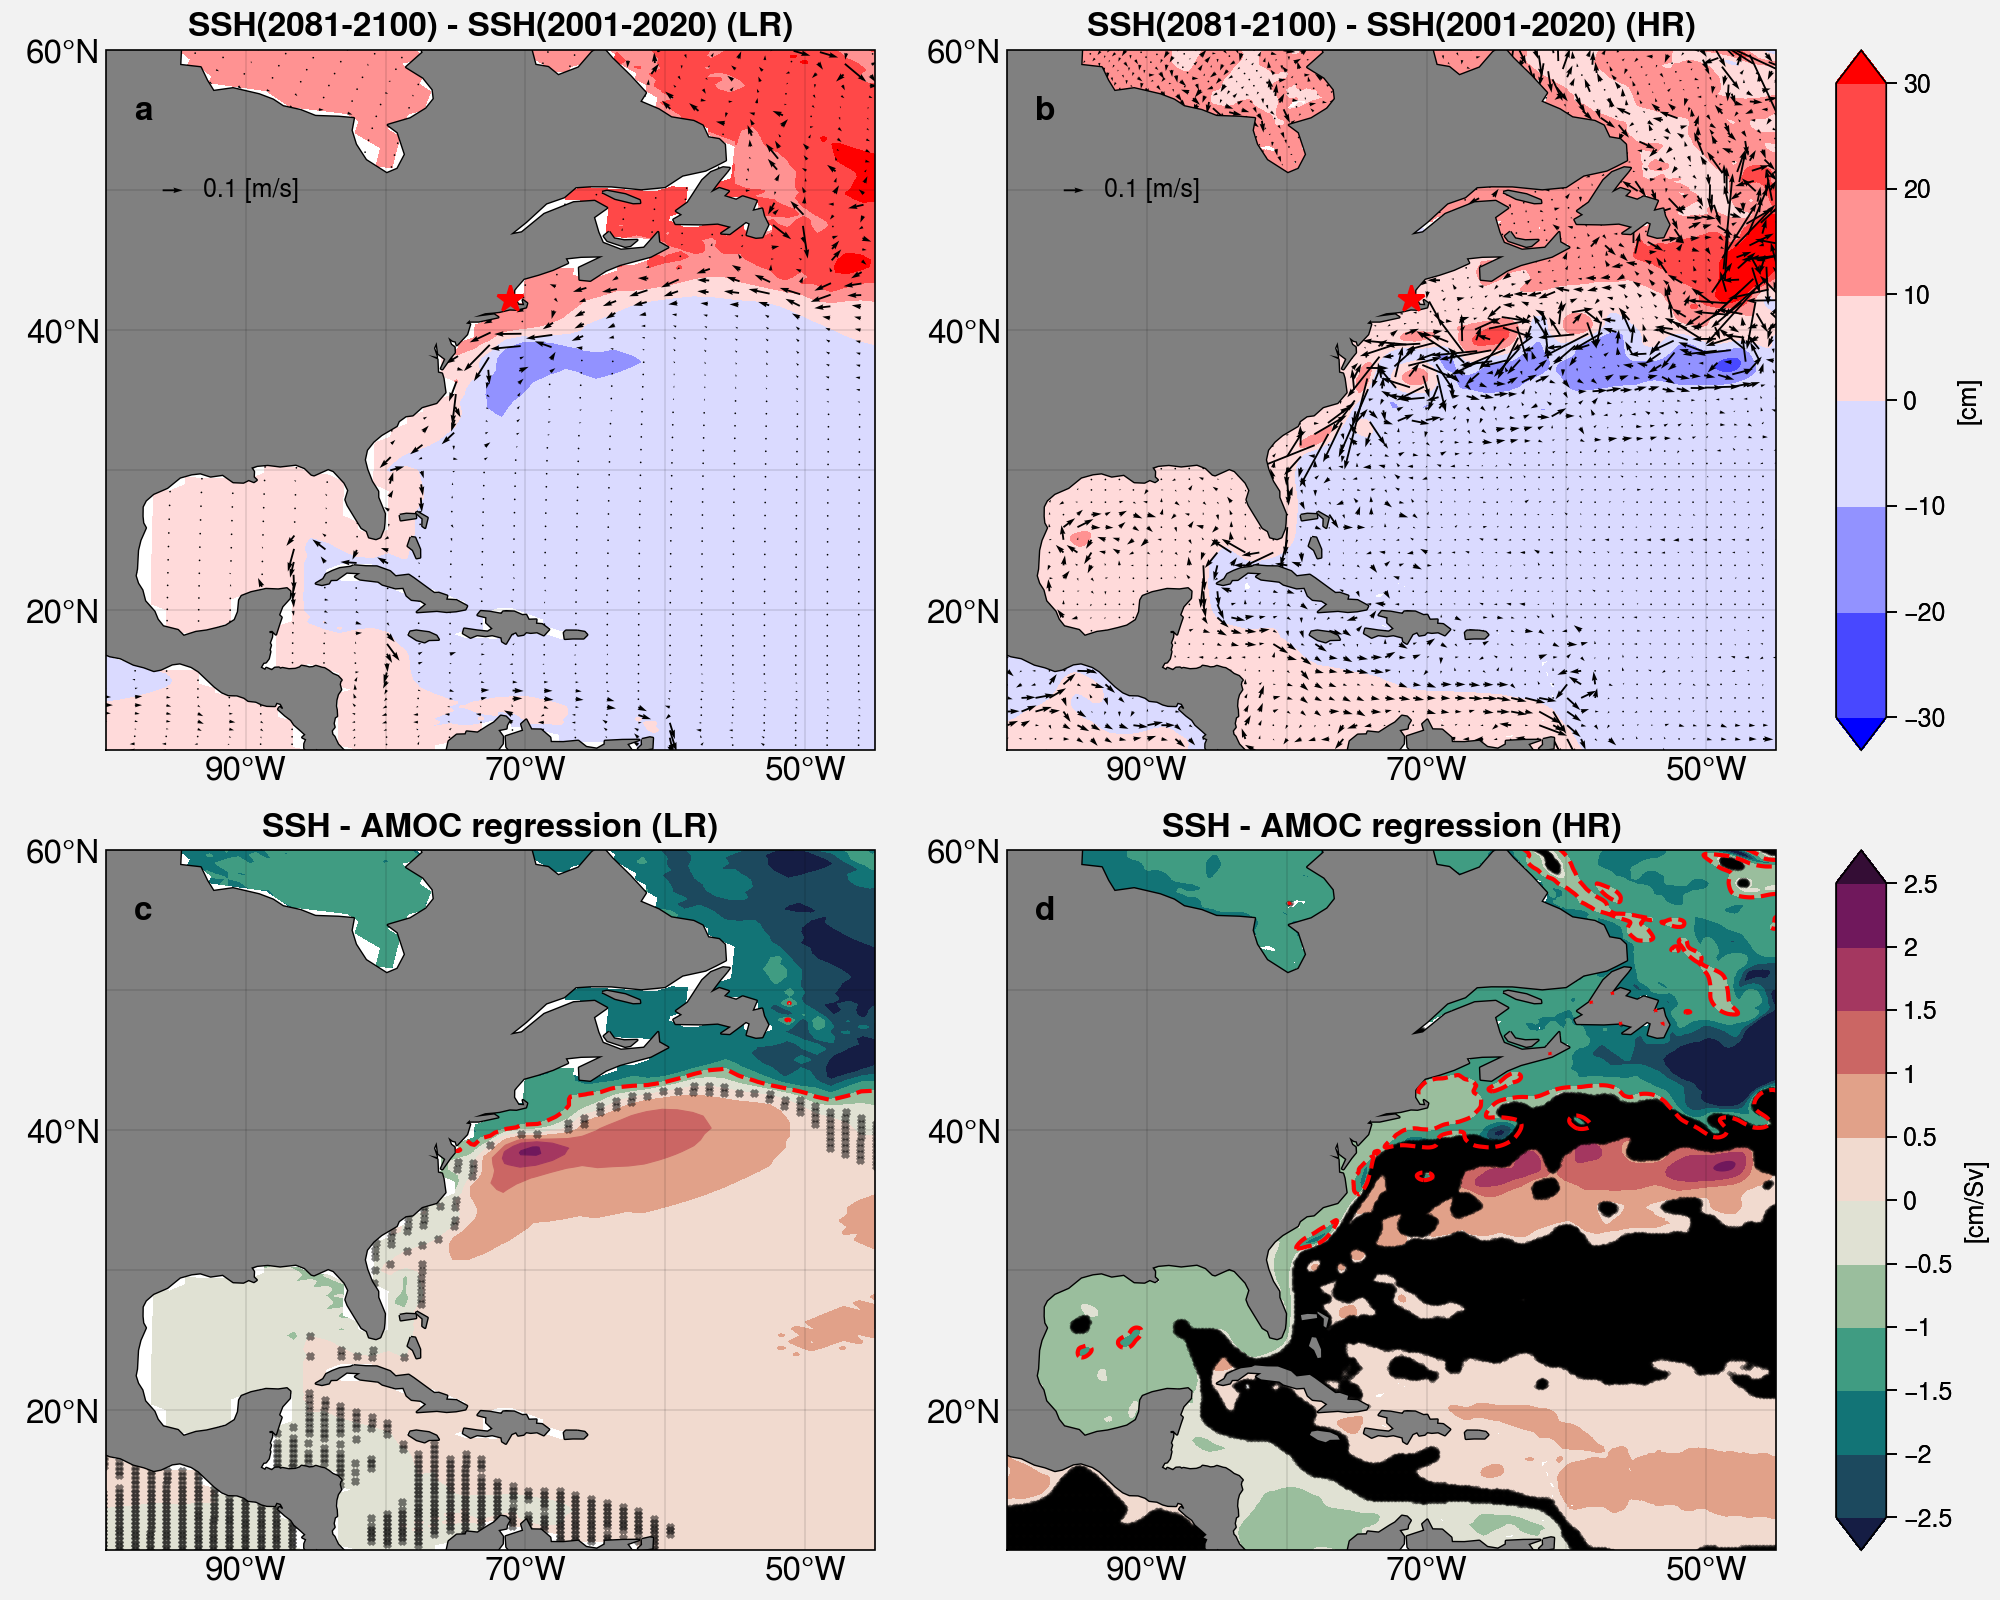

In [23]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='10in',height='8in')

m00=axs[0,0].contourf(ds_NA_g16.TLONG, ds_NA_g16.TLAT, 
        (dssh_NA_TL - dssh_NA_CL), levels=np.arange(-30,30+1,10), transform=pc, 
        vmin=-25, vmax=25, cmap="bwr", extend='both')
q00 = axs[0,0].quiver(ds_NA_g16.TLONG[::2,::2], ds_NA_g16.TLAT[::2,::2], 
                      du_NA_TLmCL[::2,::2], dv_NA_TLmCL[::2,::2], transform=pc, scale=100,scale_units='inches')
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=10,
             label='0.1 [m/s]', labelpos='E')
# axs[1,0].quiverkey(q10, X=-98, Y=55, U=10, transform=pc,
#              label='Quiver key, length = 10', labelpos='E',zorder=0)
axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
# axs[1,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,0].set_xticks(np.arange(lon1+10,lon2+1,20), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1+10,lon2+1,20), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1+10,lat2+1, 20), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1+10,lat2+1, 20), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title('SSH(2081-2100) - SSH(2001-2020) (LR)', fontsize=12, fontweight='bold')
axs[0,0].text(-98, 55, 'a', transform=pc, fontsize=12, fontweight='bold')
# cb = axs[1,0].colorbar(m10,loc='r',label='[cm]',width='2em',shrink=1)

m01=axs[0,1].contourf(ds_NA_t12.TLONG, ds_NA_t12.TLAT, 
        (dssh_NA_TH - dssh_NA_CH), levels=np.arange(-30,30+1,10), transform=pc, 
        vmin=-25, vmax=25, cmap="bwr", extend='both')
q01 = axs[0,1].quiver(ds_NA_t12.TLONG[::10,::10], ds_NA_t12.TLAT[::10,::10], 
                du_NA_THmCH[::10,::10], dv_NA_THmCH[::10, ::10], transform=pc, scale=100,scale_units='inches')
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=10,
             label='0.1 [m/s]', labelpos='E')
axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
# axs[1,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,1].set_xticks(np.arange(lon1+10,lon2+1,20), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1+10,lon2+1,20), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1+10,lat2+1, 20), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1+10,lat2+1, 20), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title('SSH(2081-2100) - SSH(2001-2020) (HR)', fontsize=12, fontweight='bold')
axs[0,1].text(-98, 55, 'b', transform=pc, fontsize=12, fontweight='bold')
cb = axs[0,1].colorbar(m01,loc='r',label='[cm]',width='2em',shrink=1)

# row 1: regress ssh to amoc
m10=axs[1,0].contourf(ds_NA_g16.TLONG, ds_NA_g16.TLAT, 
        ssh2AMOC_NA_TLmCL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        vmin=-2.5, vmax=2.5, cmap="curl", extend='both')
cs10=axs[1,0].contour(ds_NA_g16.TLONG, ds_NA_g16.TLAT, 
        ssh2AMOC_NA_TLmCL, levels=[-1], transform=pc, color='r')
axs[1,0].scatter(lonm_NA_g16, latm_NA_g16, 
        s=5, color='k', marker='x', alpha=0.5)
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
# axs[1,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,0].set_xticks(np.arange(lon1+10,lon2+1,20), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1+10,lon2+1,20), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1+10,lat2+1, 20), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1+10,lat2+1, 20), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title('SSH - AMOC regression (LR)', fontsize=12, fontweight='bold')
axs[1,0].text(-98, 55, 'c', transform=pc, fontsize=12, fontweight='bold')


m11=axs[1,1].contourf(ds_NA_t12.TLONG, ds_NA_t12.TLAT,
        ssh2AMOC_NA_THmCH, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        vmin=-2.5, vmax=2.5, cmap="curl", extend='both')
cs11=axs[1,1].contour(ds_NA_t12.TLONG, ds_NA_t12.TLAT, 
        ssh2AMOC_NA_THmCH, levels=[-1], transform=pc, color='r')
axs[1,1].scatter(lonm_NA_t12, latm_NA_t12, s=1, color='k', marker='x', alpha=0.4)
# axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
# axs[1,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,1].set_xticks(np.arange(lon1+10,lon2+1,20), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1+10,lon2+1,20), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1+10,lat2+1, 20), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1+10,lat2+1, 20), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title('SSH - AMOC regression (HR)', fontsize=12, fontweight='bold')
axs[1,1].text(-98, 55, 'd', transform=pc, fontsize=12, fontweight='bold')
cb = axs[1,1].colorbar(m11,loc='r',label='[cm/Sv]',extend='both',width='2em',shrink=1)

fig1.savefig(pic1, bbox_inches='tight')

# Appendix

In [ ]:
# first stack nlon and nlat then loop to compute linear regression
# sshs_yr_NA_THmCH = ssh_yr_NA_THmCH.stack(latlon=("nlat", "nlon")) # s: stack
# sshs_yr_NA_TLmCL = ssh_yr_NA_TLmCL.stack(latlon=("nlat", "nlon"))

# sshs_yr_NA_THmCH = ssh_yr_NA_THmCH.stack(latlon=("nlat", "nlon")) # s: stack
# sshs_yr_NA_THmCH
# ntime, nlatlon = sshs_yr_NA_THmCH.shape

# ssh2AMOC_NA_THmCH = np.empty(sshs_yr_NA_THmCH.shape)
# ssh2AMOC_NA_THmCH[:] = np.nan
# p_NA_THmCH = np.empty(sshs_yr_NA_THmCH.shape)
# p_NA_THmCH[:] = np.nan

# sshs_yr_NA_THmCH.sel(time=slice('2000','2100')).shape

# sshs_yr_NA_THmCH = ssh_yr_NA_THmCH.stack(latlon=("nlat", "nlon")) # s: stack
# sshs_yr_NA_THmCH
# ntime, nlatlon = sshs_yr_NA_THmCH.shape

# ssh2AMOC_NA_THmCH = np.empty((nlatlon,1))
# ssh2AMOC_NA_THmCH[:] = np.nan
# p_NA_THmCH = np.empty((nlatlon,1))
# p_NA_THmCH[:] = np.nan
# ssh2AMOC_NA_THmCH.shape

# %%time 
# # running time: ~20 min 
# ntime, nlat_NA_t12, nlon_NA_t12 = ssh_yr_NA_THmCH.sel(time=slice('2000','2100')).shape
# ssh2AMOC_NA_THmCH = np.empty((nlat_NA_t12, nlon_NA_t12))
# ssh2AMOC_NA_THmCH[:] = np.nan
# p_NA_THmCH = np.empty((nlat_NA_t12, nlon_NA_t12))
# p_NA_THmCH[:] = np.nan
# # pp_TLmCL = np.zeros((nlat_NA_g16, nlon_NA_g16))


# for ilon in np.arange(0,nlon_NA_t12):
# #     print(ilon)
#     for ilat in np.arange(0,nlat_NA_t12):
# #         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#         ssh2AMOC_NA_THmCH[ilat,ilon], _, _, p_NA_THmCH[ilat,ilon], _ = stats.linregress(MOC45_yr_THmCH.sel(time=slice('2000','2100')),
#                                                                                   ssh_yr_NA_THmCH.sel(time=slice('2000','2100'))[:,ilat,ilon])
    
# # px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# # px_NA_TLmCL

# lat_NA_t12 = ds_NA_t12.TLAT#.where(px_NA_TLmCL>0.05)
# latm_NA_t12 = np.where(p_NA_THmCH>0.05,lat_NA_t12, np.nan) # m: mask

# lon_NA_t12 = ds_NA_t12.TLONG#.where(px_NA_TLmCL>0.05)
# lonm_NA_t12 = np.where(p_NA_THmCH>0.05,lon_NA_t12, np.nan) # m: mask

# # x = MOC45_yr_TLmCL.sel(time=slice('2000','2100'))
# # y = sshs_yr_NA_TLmCL.sel(time=slice('2000','2100')).isel()
# # print(x.shape)
# # print(y.shape)

# # slope = np.empty((10200,))
# # slope[:] = np.nan
# # p_value = slope.copy()

# # for i in np.arange(0,10200):
# # #     print(i)
# #     slope[i], _, _, p_value[i], _ = stats.linregress(x,y[:,i])
    
# #     # slope
# # sloper = slope.reshape(ssh_yr_NA_TLmCL.isel(time=0).shape)
# # p_valuer = p_value.reshape(ssh_yr_NA_TLmCL.isel(time=0).shape)

In [ ]:
# sshs_yr_NA_THmCH = ssh_yr_NA_THmCH.stack(latlon=("nlat", "nlon")) # s: stack
# sshs_yr_NA_TLmCL = ssh_yr_NA_TLmCL.stack(latlon=("nlat", "nlon"))
# sshs_yr_NA_THmCH

# a = MOC45_yr_TLmCL.rolling(time=10, center=True).mean().sel(time=slice('2000','2100'))
# a

# ssh2AMOCs_NA_TLmCL = np.polyfit(MOC45_yr_TLmCL.sel(time=slice('2000','2100')), 
#                                 sshs_yr_NA_TLmCL.sel(time=slice('2000','2100')), deg=1) # s: stack
# ssh2AMOCs_NA_THmCH = np.polyfit(MOC45_yr_THmCH.sel(time=slice('2000','2100')), 
#                                 sshs_yr_NA_THmCH.sel(time=slice('2000','2100')), deg=1)
# ssh2AMOCs_NA_THmCH.shape

# print(ssh_yr_NA_TLmCL.isel(time=0).shape)
# print(ssh_yr_NA_THmCH.isel(time=0).shape)

# ssh2AMOCnp_NA_THmCH = ssh2AMOCs_NA_THmCH[0].reshape(ssh_yr_NA_THmCH.isel(time=0).shape) # np: numpy array
# ssh2AMOCnp_NA_TLmCL = ssh2AMOCs_NA_TLmCL[0].reshape(ssh_yr_NA_TLmCL.isel(time=0).shape)

# ssh2AMOC_NA_THmCH = xr.DataArray(data=ssh2AMOCnp_NA_THmCH, dims=["nlon","nlat"]) # convert numpy to xarray
# ssh2AMOC_NA_TLmCL = xr.DataArray(data=ssh2AMOCnp_NA_TLmCL, dims=["nlon","nlat"])
# ssh2AMOC_NA_THmCH

In [ ]:
m00=axs[0,0].contourf(ds_NA_g16.TLONG, ds_NA_g16.TLAT, 
        ssh2AMOC_NA_TLmCL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        vmin=-2.5, vmax=2.5, cmap="curl", extend='both')

In [11]:
sshs_yr_TH =ssh_yr_TH.stack(latlon=("nlat", "nlon")) # s: stack
sshs_yr_TL =ssh_yr_TL.stack(latlon=("nlat", "nlon"))
sshs_yr_TH 

<xarray.DataArray 'SSH' (time: 251, latlon: 360000)>
array([[34.400337, 34.243893, 34.122112, ...,       nan,       nan,
              nan],
       [36.639233, 36.498375, 36.40364 , ...,       nan,       nan,
              nan],
       [38.477276, 38.354996, 38.261066, ...,       nan,       nan,
              nan],
       ...,
       [37.978695, 37.865494, 37.714527, ...,       nan,       nan,
              nan],
       [37.660374, 37.555344, 37.435513, ...,       nan,       nan,
              nan],
       [37.822224, 37.653687, 37.474293, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG    (latlon) float64 260.1 260.1 260.2 260.3 ... 315.4 315.6 315.7
    TLAT     (latlon) float64 11.77 11.77 11.77 11.77 ... 61.79 61.8 61.81 61.82
  * latlon   (latlon) MultiIndex
  - nlat     (latlon) int64 0 0 0 0 0 0 0 0 ... 599 599 599 599 599 599 599 599
  - nlon     (latlon) int64 0 1 2 3 4 5 6 7 ... 592 593 594 595 596 597 598 599

In [12]:
ssh2AMOCs_TL = np.polyfit(MOC45_yr_TL.sel(time=slice('2000','2100')), sshs_yr_TL.sel(time=slice('2000','2100')), deg=1)
ssh2AMOCs_TH = np.polyfit(MOC45_yr_TH.sel(time=slice('2000','2100')), sshs_yr_TH.sel(time=slice('2000','2100')), deg=1)
ssh2AMOCs_TH.shape

(2, 360000)

In [47]:
ssh2AMOC_TH = ssh2AMOCs_TH[0].reshape(600,600)
ssh2AMOC_TL = ssh2AMOCs_TL[0].reshape(120,55)
ssh2AMOC_TH

array([[-5.05337403e-01, -5.18212027e-01, -5.22682611e-01, ...,
         3.95773933e-01,  3.92379186e-01,  3.98694430e-01],
       [-4.99641818e-01, -5.04348511e-01, -5.17537561e-01, ...,
         4.00625414e-01,  4.07152571e-01,  4.02984500e-01],
       [-4.85356624e-01, -4.97617540e-01, -5.02696660e-01, ...,
         4.13892261e-01,  4.09830938e-01,  4.15157233e-01],
       ...,
       [-9.26382364e-19, -9.26382364e-19, -9.26382364e-19, ...,
                    nan,             nan,             nan],
       [-9.26382364e-19, -9.26382364e-19, -9.26382364e-19, ...,
                    nan,             nan,             nan],
       [-9.26382364e-19, -9.26382364e-19, -9.26382364e-19, ...,
                    nan,             nan,             nan]])

In [48]:
ssh2AMOCx_TH = xr.DataArray(data=ssh2AMOC_TH, dims=["nlon","nlat"])
ssh2AMOCx_TL = xr.DataArray(data=ssh2AMOC_TL, dims=["nlon","nlat"])
ssh2AMOCx_TH

<xarray.DataArray (nlon: 600, nlat: 600)>
array([[-5.05337403e-01, -5.18212027e-01, -5.22682611e-01, ...,
         3.95773933e-01,  3.92379186e-01,  3.98694430e-01],
       [-4.99641818e-01, -5.04348511e-01, -5.17537561e-01, ...,
         4.00625414e-01,  4.07152571e-01,  4.02984500e-01],
       [-4.85356624e-01, -4.97617540e-01, -5.02696660e-01, ...,
         4.13892261e-01,  4.09830938e-01,  4.15157233e-01],
       ...,
       [-9.26382364e-19, -9.26382364e-19, -9.26382364e-19, ...,
                    nan,             nan,             nan],
       [-9.26382364e-19, -9.26382364e-19, -9.26382364e-19, ...,
                    nan,             nan,             nan],
       [-9.26382364e-19, -9.26382364e-19, -9.26382364e-19, ...,
                    nan,             nan,             nan]])
Dimensions without coordinates: nlon, nlat

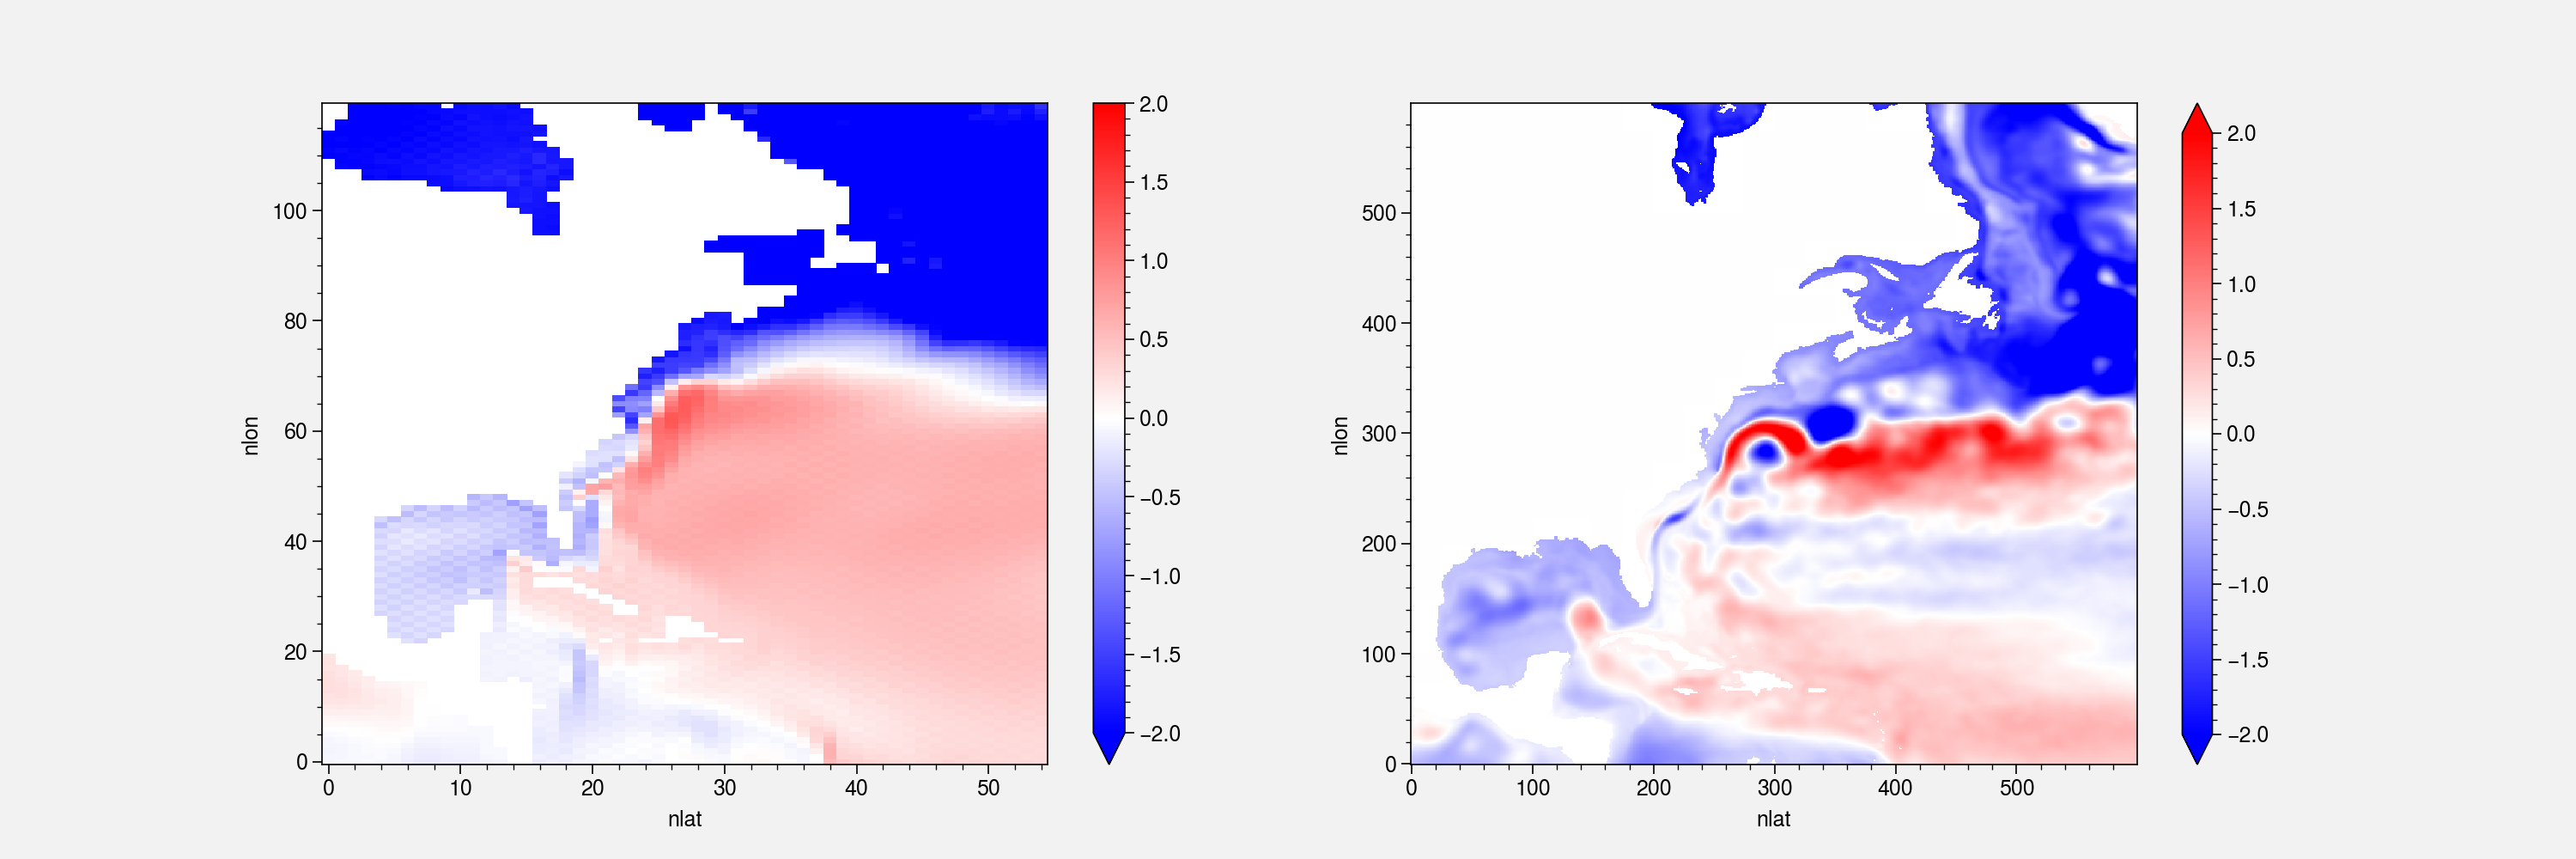

In [49]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
ssh2AMOCx_TL.plot(ax=axs[0], vmin=-2, vmax=2, cmap='bwr')
ssh2AMOCx_TH.plot(ax=axs[1], vmin=-2, vmax=2, cmap='bwr')

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


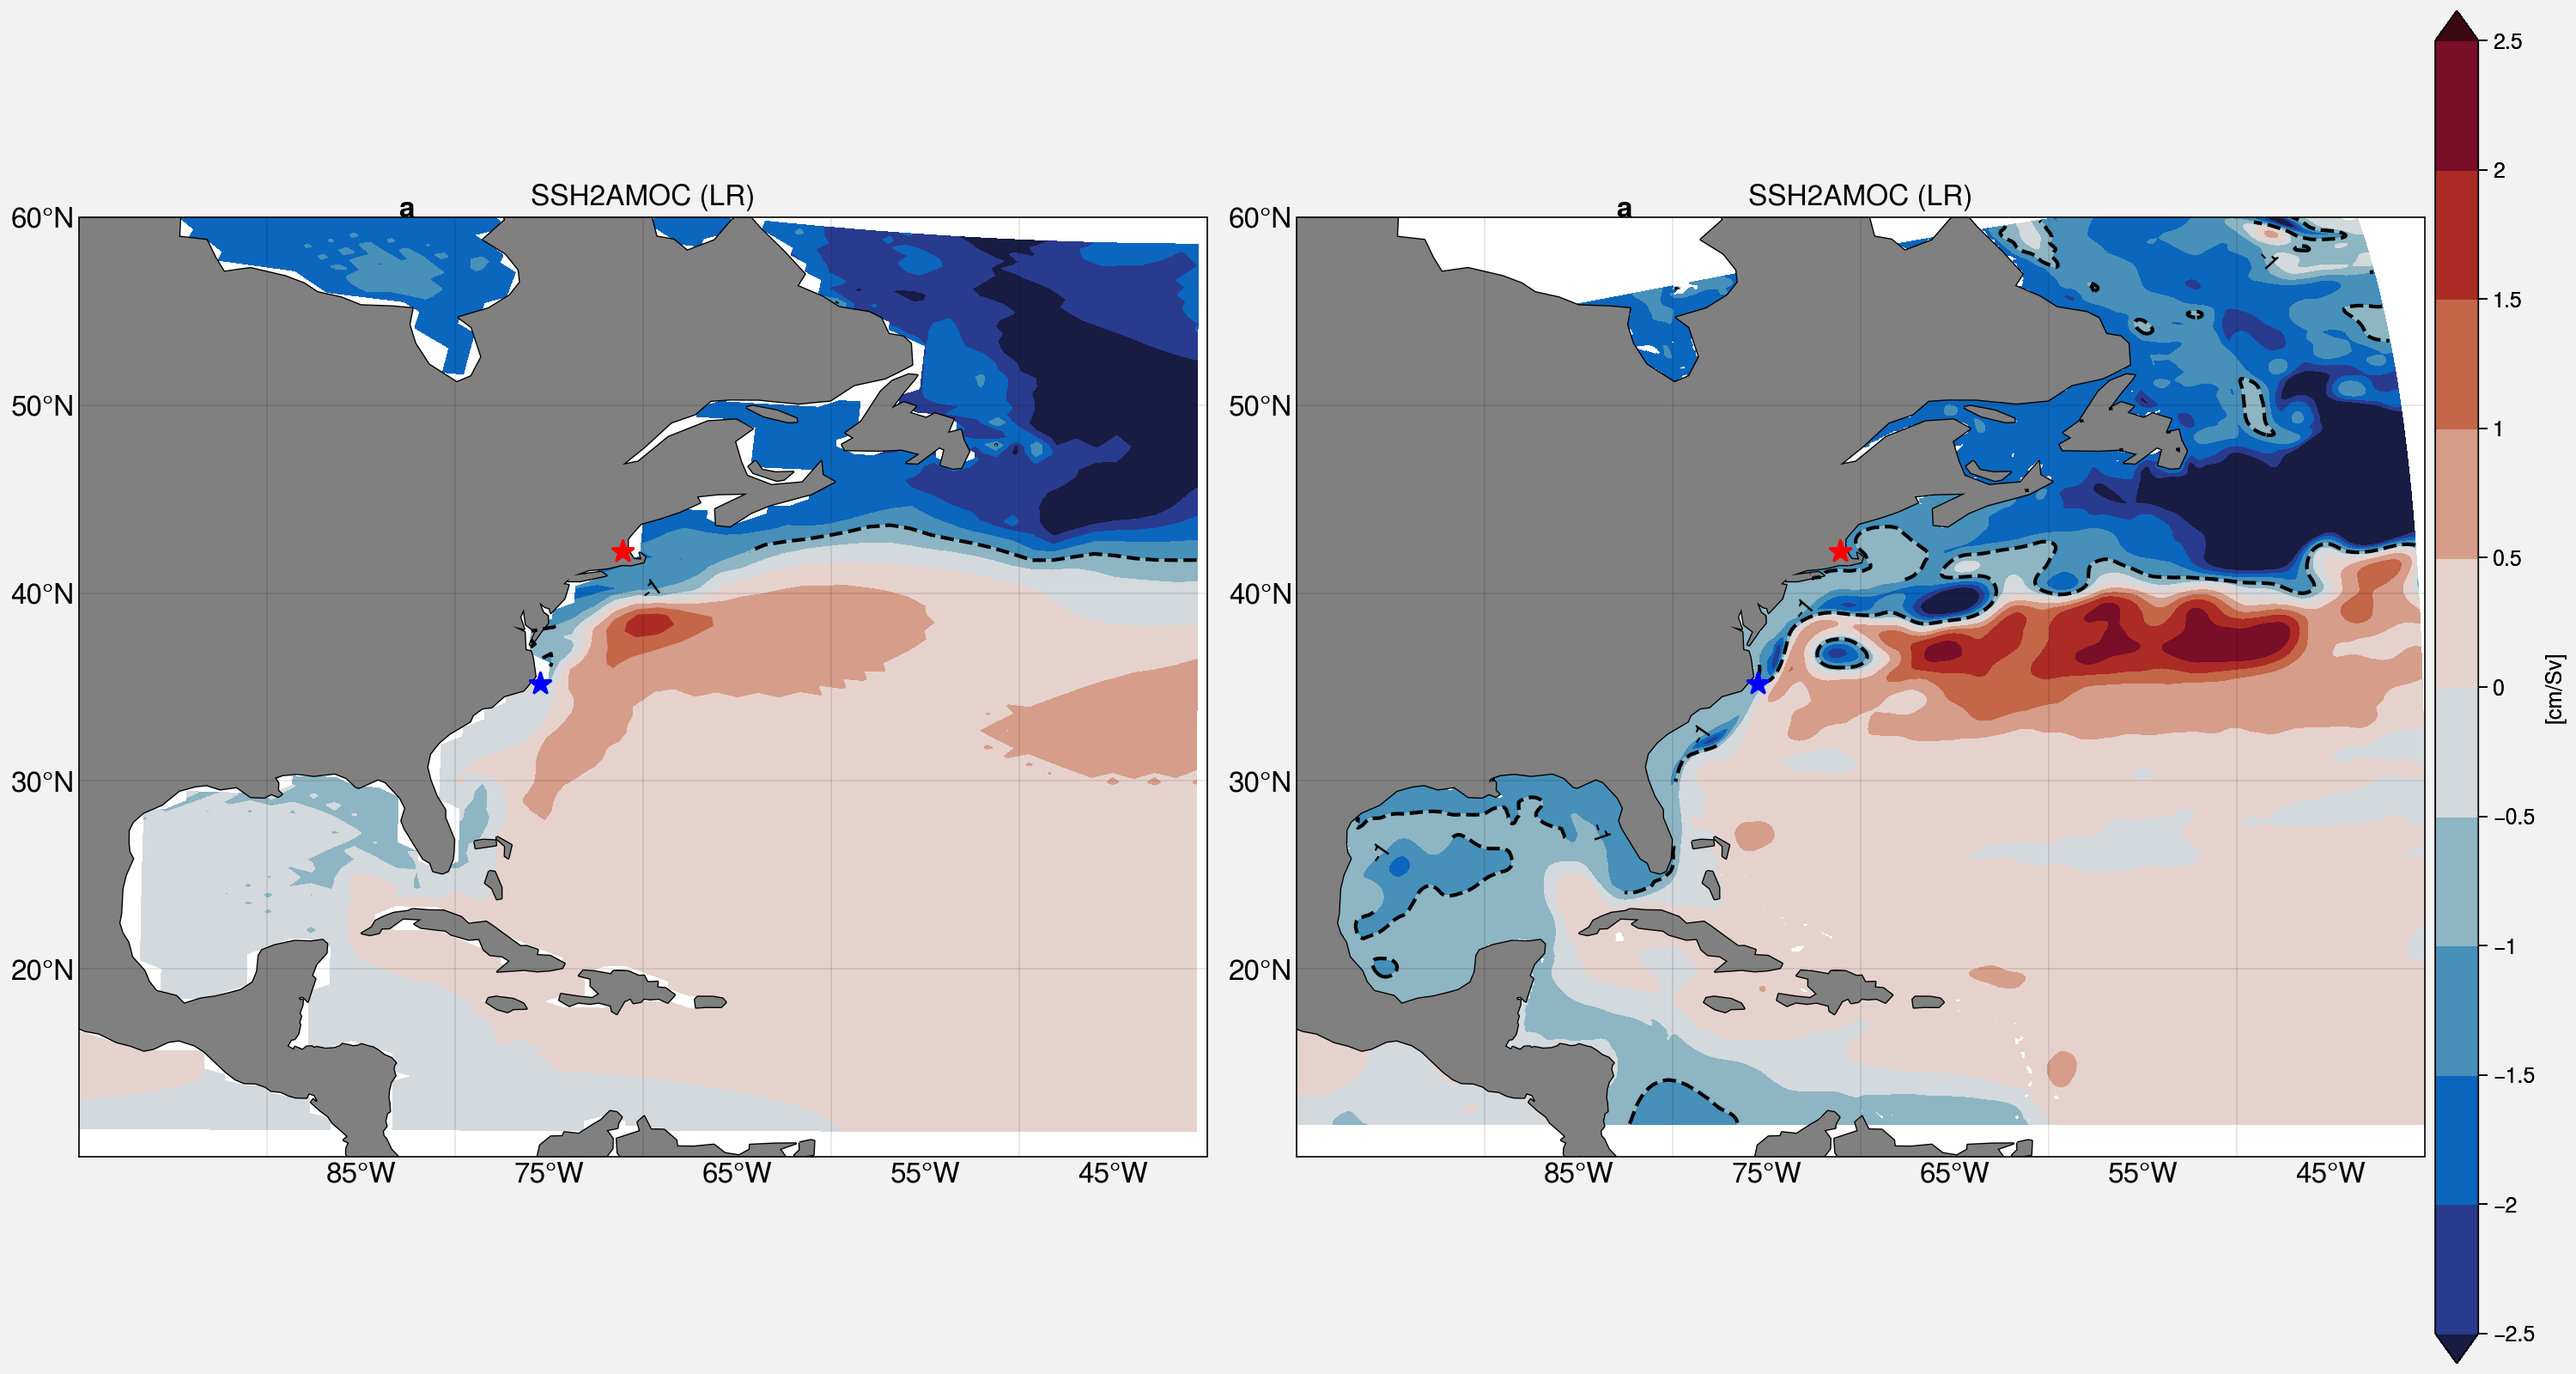

In [38]:
# pc = cartopy.crs.PlateCarree()
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()

# fig1, axs = plot.subplots(nrows=1,ncols=2,proj='cyl',width='15in',height='8in')

# # row 1: projected ssh change
# m00=axs[0,0].contourf(ssh_yr_TL.TLONG, ssh_yr_TL.TLAT, 
#         ssh2AMOCx_TL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
#         vmin=-2.5, vmax=2.5, cmap="balance", extend='both')
# cs00=axs[0,0].contour(ssh_yr_TL.TLONG, ssh_yr_TL.TLAT, 
#         ssh2AMOCx_TL, levels=[-1], transform=pc, 
#         vmin=-2.5, vmax=2.5, color='k')
# axs[0,0].clabel(cs00, inline=True, fmt='%d', fontsize=10)

# # m00=axs[0,0].contourf(ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).longitude, ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).latitude, 
# #         dssh_TL.sel(i=slice(200,280),j=slice(200,300)),  transform=pc, 
# #          cmap="bwr", extend='both')
# # axs[0,0].quiver(du_rgd_NA_TH.lon, du_rgd_NA_TH.lat, 
# #                 du_rgd_NA_TH, dv_rgd_NA_TH, transform=pc,color='k')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# # Cape Hatters (75.5W, 35.2N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# lon1,lon2 = -100, -40
# lat1,lat2 = 10, 60
# axs[0,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
# axs[0,0].set_xticks(np.arange(-85,-40+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(-85,-40+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title('SSH2AMOC (LR)', fontsize=12)
# axs[0,0].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
# # cb = axs[0,0].colorbar(m00,loc='r',label='[cm]',extend='both',width='2em',shrink=1)

# #  row 1: projected ssh change
# m01=axs[0,1].contourf(ssh_yr_TH.TLONG, ssh_yr_TH.TLAT, 
#         ssh2AMOCx_TH, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
#         vmin=-2.5, vmax=2.5, cmap="balance", extend='both')
# cs01=axs[0,1].contour(ssh_yr_TH.TLONG, ssh_yr_TH.TLAT, 
#         ssh2AMOCx_TH, levels=[-1], transform=pc, 
#         vmin=-2.5, vmax=2.5, color='k')
# axs[0,1].clabel(cs01, inline=True, fmt='%d', fontsize=10)
# # m00=axs[0,0].contourf(ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).longitude, ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).latitude, 
# #         dssh_TL.sel(i=slice(200,280),j=slice(200,300)),  transform=pc, 
# #          cmap="bwr", extend='both')
# # axs[0,0].quiver(du_rgd_NA_TH.lon, du_rgd_NA_TH.lat, 
# #                 du_rgd_NA_TH, dv_rgd_NA_TH, transform=pc,color='k')
# axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# # Cape Hatters (75.5W, 35.2N)
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# lon1,lon2 = -100, -40
# lat1,lat2 = 10, 60
# axs[0,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
# axs[0,1].set_xticks(np.arange(-85,-40+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(-85,-40+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(20,60+1,10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title('SSH2AMOC (LR)', fontsize=12)
# axs[0,1].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
# cb = axs[0,1].colorbar(m01,loc='r',label='[cm/Sv]',extend='both',width='2em',shrink=1)

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


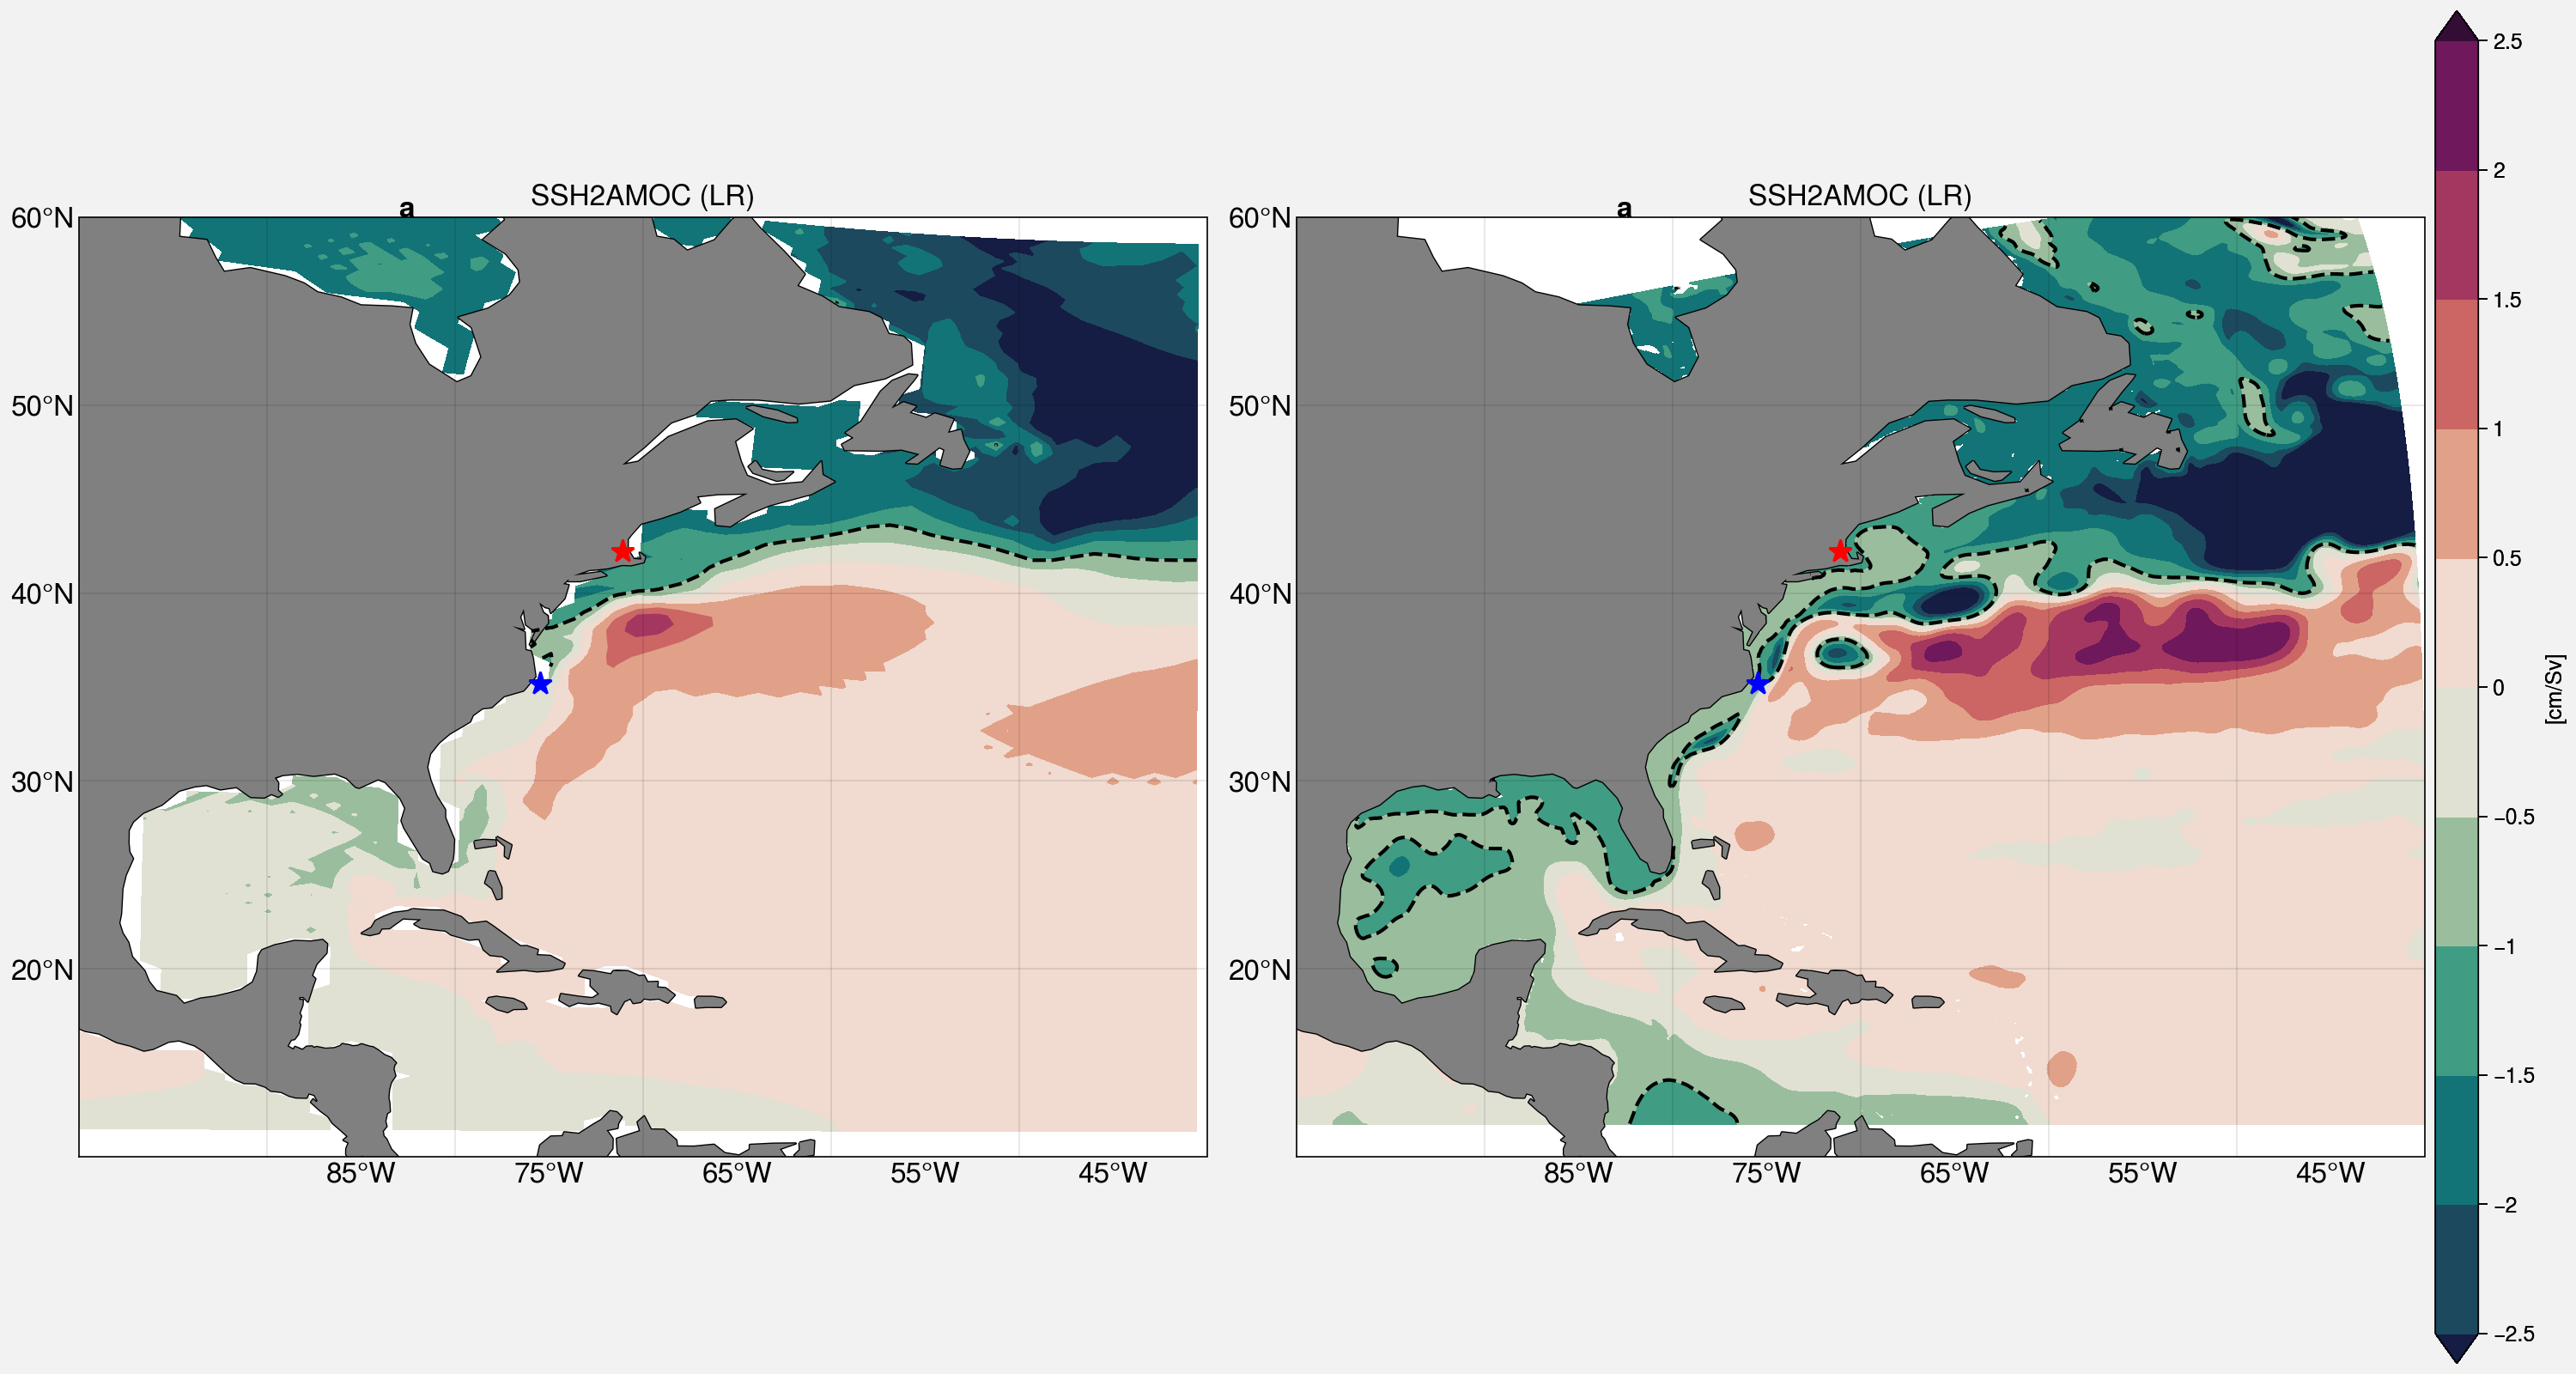

In [41]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=1,ncols=2,proj='cyl',width='15in',height='8in')

# row 1: projected ssh change
m00=axs[0,0].contourf(ssh_yr_TL.TLONG, ssh_yr_TL.TLAT, 
        ssh2AMOCx_TL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        vmin=-2.5, vmax=2.5, cmap="curl", extend='both')
cs00=axs[0,0].contour(ssh_yr_TL.TLONG, ssh_yr_TL.TLAT, 
        ssh2AMOCx_TL, levels=[-1], transform=pc, 
        vmin=-2.5, vmax=2.5, color='k')
# axs[0,0].clabel(cs00, inline=True, fmt='%d', fontsize=10)

# m00=axs[0,0].contourf(ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).longitude, ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).latitude, 
#         dssh_TL.sel(i=slice(200,280),j=slice(200,300)),  transform=pc, 
#          cmap="bwr", extend='both')
# axs[0,0].quiver(du_rgd_NA_TH.lon, du_rgd_NA_TH.lat, 
#                 du_rgd_NA_TH, dv_rgd_NA_TH, transform=pc,color='k')
axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
lon1,lon2 = -100, -40
lat1,lat2 = 10, 60
axs[0,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,0].set_xticks(np.arange(-85,-40+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(-85,-40+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title('SSH2AMOC (LR)', fontsize=12)
axs[0,0].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
# cb = axs[0,0].colorbar(m00,loc='r',label='[cm]',extend='both',width='2em',shrink=1)

#  row 1: projected ssh change
m01=axs[0,1].contourf(ssh_yr_TH.TLONG, ssh_yr_TH.TLAT, 
        ssh2AMOCx_TH, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        vmin=-2.5, vmax=2.5, cmap="curl", extend='both')
cs01=axs[0,1].contour(ssh_yr_TH.TLONG, ssh_yr_TH.TLAT, 
        ssh2AMOCx_TH, levels=[-1], transform=pc, 
        vmin=-2.5, vmax=2.5, color='k')
# axs[0,1].clabel(cs01, inline=True, fmt='%d', fontsize=10)
# m00=axs[0,0].contourf(ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).longitude, ssh1_TL.sel(i=slice(200,280),j=slice(200,300)).latitude, 
#         dssh_TL.sel(i=slice(200,280),j=slice(200,300)),  transform=pc, 
#          cmap="bwr", extend='both')
# axs[0,0].quiver(du_rgd_NA_TH.lon, du_rgd_NA_TH.lat, 
#                 du_rgd_NA_TH, dv_rgd_NA_TH, transform=pc,color='k')
axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
lon1,lon2 = -100, -40
lat1,lat2 = 10, 60
axs[0,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,1].set_xticks(np.arange(-85,-40+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(-85,-40+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title('SSH2AMOC (LR)', fontsize=12)
axs[0,1].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
cb = axs[0,1].colorbar(m01,loc='r',label='[cm/Sv]',extend='both',width='2em',shrink=1)

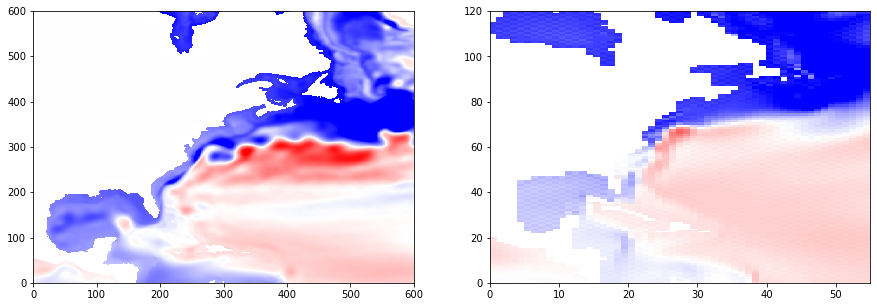

In [72]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].pcolormesh(ssh2AMOC_TH,cmap='bwr',vmin=-2,vmax=2)
axs[1].pcolormesh(ssh2AMOC_TL,cmap='bwr',vmin=-2,vmax=2)

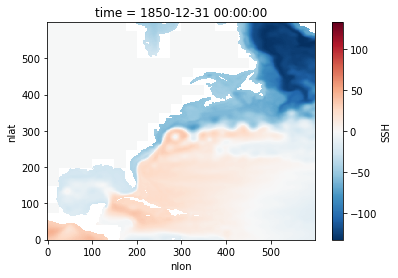

In [17]:
a.unstack("z").isel(time=0).plot()